# Ball and Racket

Sotiropoulos et al. [1] proposes to use a Ball and $N$ Bingham distributions of Sticks to describe axon dispersion in tissues with $N\geq1$ axon bundle populations. A Bingham distribution $B(\kappa_1,\kappa_2,\boldsymbol{\mu})$, oriented along orientation $\boldsymbol{\mu}\in\mathbb{S}^2$, quantifies the dispersion of Sticks around $\boldsymbol{\mu}$.
When $\kappa_1\neq\kappa_2$ the Bingham model describes "fanning" or "bending" axon populations [2].
The existence of such configurations has been confirmed with histology in the cortex [3], corpus callosum [2] and corticospinal tracts [3].
Aptly, this model is called Ball and Rackets (BAR). The "Racket" presumably comes from the fanning of strings on a tennis racket. Bar describes the diffusion signal as

\begin{align}
 E^{\textrm{Ball and}}_{\textrm{Rackets}}= \underbrace{f_{\textrm{iso}}\overbrace{E_{\textrm{iso}}(D_{\textrm{iso}})}^{\textrm{Ball}}}_{\textrm{Extra-Axonal}} +\sum_{i=1}^N\underbrace{f_r^i\overbrace{B(\kappa_1,\kappa_2,\boldsymbol{\mu})}^{\textrm{Bingham}}\,*_{\mathbb{S}^2}\,\overbrace{E_r(\cdot|\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}
\end{align}

where $*_{\mathbb{S}^2}$ denotes the spherical convolution of the Bingham distribution with the convolution kernel, i.e. the Stick. As such, BAR was the first model designed to estimate axon dispersion and fanning separately \emph{per} axon bundle. However, as extra-axonal diffusion in between axons is hindered and anisotropic [6], lumping it all together in one isotropic compartment will likely bias estimated model parameters. Moreover, they found that estimating dispersion in crossing tissue configurations in the presence of noise is highly unstable, effectly limiting its application to voxels with one axon bundle when $N=1$. 

[1] Sotiropoulos  
[2] kaden2007parametric  
[3] kleinnijenhuis2013detailed  
[4] budde2013quantification  
[5] ture2000fiber  
[6] assaf2004new

## Generate Ball and Racket model

In [2]:
from microstruktur.signal_models import gaussian_models, cylinder_models
from microstruktur.distributions.distribute_models import SD2BinghamDistributed
from microstruktur.core.modeling_framework import MultiCompartmentModel
ball = gaussian_models.G3Ball()
stick = cylinder_models.C1Stick()
dispersed_stick = SD2BinghamDistributed([stick])
BAR_mod = MultiCompartmentModel(models=[dispersed_stick, ball])

In [3]:
BAR_mod.parameter_cardinality

OrderedDict([('SD2BinghamDistributed_1_SD2Bingham_1_beta_fraction', 1),
             ('SD2BinghamDistributed_1_SD2Bingham_1_odi', 1),
             ('SD2BinghamDistributed_1_SD2Bingham_1_mu', 2),
             ('SD2BinghamDistributed_1_SD2Bingham_1_psi', 1),
             ('G3Ball_1_lambda_iso', 1),
             ('SD2BinghamDistributed_1_C1Stick_1_lambda_par', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

In [4]:
BAR_mod.fix_parameter("SD2BinghamDistributed_1_C1Stick_1_lambda_par", 1.7e-9)

In [5]:
BAR_mod.parameter_cardinality

OrderedDict([('SD2BinghamDistributed_1_SD2Bingham_1_beta_fraction', 1),
             ('SD2BinghamDistributed_1_SD2Bingham_1_odi', 1),
             ('SD2BinghamDistributed_1_SD2Bingham_1_mu', 2),
             ('SD2BinghamDistributed_1_SD2Bingham_1_psi', 1),
             ('G3Ball_1_lambda_iso', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

# Human Connectome Project Example

In [6]:
from microstruktur.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data originates from Subject 100307 of the WU-Minn Human Connectome Project. View terms of use at https://store.humanconnectome.org/data/data-use-terms/open-access.php


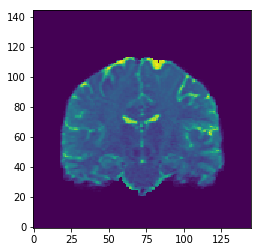

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(data_hcp[:,0,:,0].T, origin=True)

## Fit NODDI to HCP data

In [8]:
BAR_fit_hcp = BAR_mod.fit(scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0, Ns=6)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 165.60334897 seconds
Fitting of 8181 voxels complete in 3578.77901888 seconds.
Average of 0.437450069537 seconds per voxel.


## Visualize results

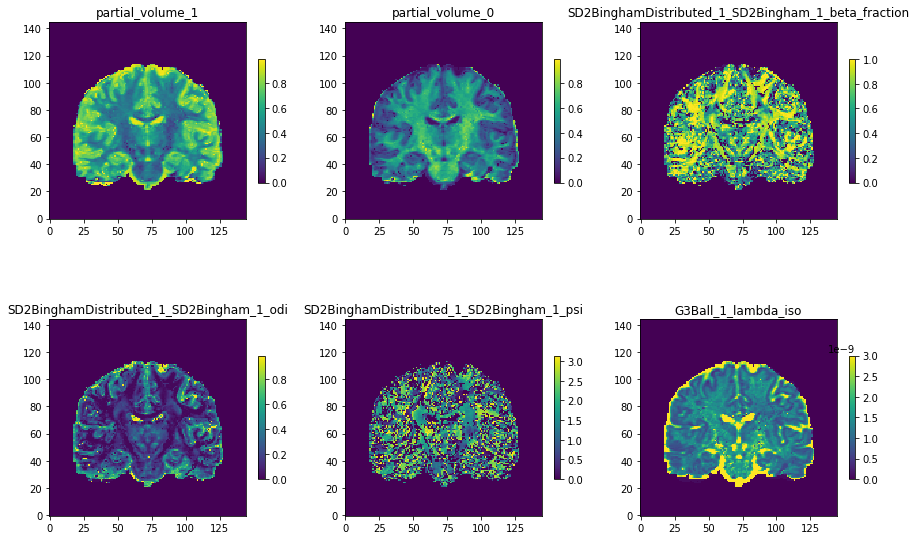

In [15]:
fitted_parameters = BAR_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

Notice that we get some familiar maps, where the Ball model takes the role of extra-axonal and CSF compartments, and the stick takes the intra-axonal compartment.

The more unfamiliar maps are those of $\beta$, $\kappa$ and $\psi$. $\kappa$ represents primary isotropic concentration as in NODDI, while $\beta$ describes the anisotropy of the concentration (bending or fanning tissue). $\psi$ describes the angle of the anisotropy.

Also notice that the maps are not completely smooth (especially lambda_par) as optimization can still fall in a local minima despite the brute force optimization. 

## Estimating Fiber Orientation Distributions (FODs)

We estimate FODs on the right side of the corpus callosum and use the estimated concentration $\kappa$ as background.

In [10]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
sphere = get_sphere(name='symmetric724')
fods = BAR_fit_hcp.fod(sphere.vertices)

In [16]:
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

kappa_res = fitted_parameters['SD2BinghamDistributed_1_SD2Bingham_1_beta_fraction']
kappa_res.shape
kappa_im = slicer(kappa_res[70:90,0, 70:90],interpolation='nearest', affine=affine, opacity=0.7)

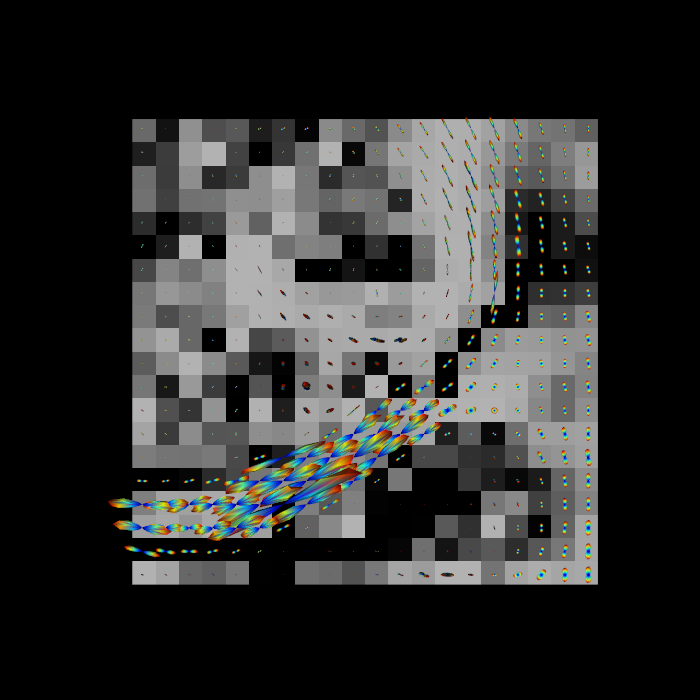

In [17]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, kappa_im)
fvtk.record(ren=ren, size=[700, 700])

from IPython.display import Image
Image(filename='dipy.png', width=700)

You can see the corpus callosum coming in the from the left and joining the centrum semiovale on the right. The intensity of the background shows the concentration $\kappa$ of the Watson distribution. Notice it is high in the corpus callosum and lower in non-white matter areas. Also notice that in the CSF on the bottom you see very high $\kappa$, but it means nothing since the intra-axonal volume fraction close to zero in these areas. Also notice that Ball and Racket cannot estimate crossings, which are expected in the centrum semiovale on the right. Using multiple compartments to model crossings is explored in the Microstructure in Crossings examples.

In [18]:
from os import remove
remove('dipy.png')

## Estimating Error Metrics: MSE and $R^2$

Whenever you fit a model, it's always wise to check out the error of the model fit. Here we estimate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination. In MSE the lower is better, while $R^2$ has an upper bound of one, which represents a perfect model fit.

/home/rutger/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/fitted_modeling_framework.py:124: RuntimeWarning: invalid value encountered in divide
  data_ = data / self.S0[..., None]
/home/rutger/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/fitted_modeling_framework.py:104: RuntimeWarning: invalid value encountered in divide
  data_ = data / self.S0[..., None]


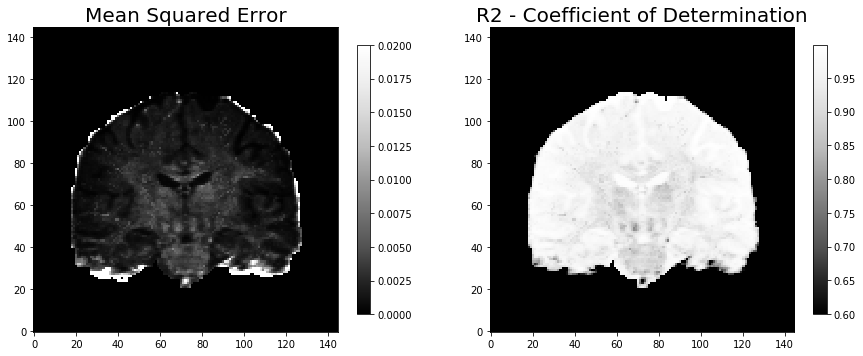

In [14]:
mse = BAR_fit_hcp.mean_squared_error(data_hcp)
R2 = BAR_fit_hcp.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=0.02, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=0.6, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);

Ideally, you want the MSE and $R^2$ to show no structure of the underlying data - which would mean the model can at least fit the data equally well everywhere. Instead, in Ball and Racket we can see clearly see the structure of the different brain areas. This means that Ball and Racket model cannot fit the diffusion equally well in all brian areas, and that interpretation of model parameters will be biased when comparing them between these different areas.

When doing these studies, ALWAYS verify whether differences in estimated parameters reflect actual tissue changes, or only reflect the limitations of the model itself.